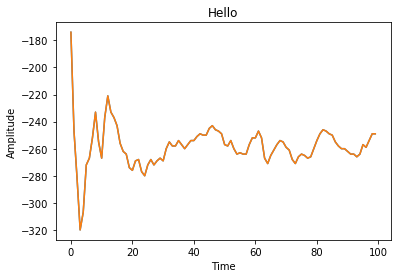

In [10]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

# read audio samples
input_data = read("hello.wav")
audio = input_data[1]
# plot first 100 
plt.plot(audio[0:100])
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time")
# set the title  
plt.title("Hello")
# display the plot
plt.show()

In [9]:
len(audio)

8111